In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skfuzzy as fuzz 
from skfuzzy import control as ctrl
from tqdm.auto import tqdm

/home/rodrigosobrinho/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
version = '1.0.1'
from IPython.core.magic import register_cell_magic

# Esta função escreve e roda as células marcadas como `prototype`
@register_cell_magic
def prototype(line, cell):
    argz = line.split()
    file = argz[-1]
    mode = 'w'
    if len(argz) == 2 and argz[0] == '-a':
        mode = 'a'
    with open(file, mode, encoding='utf-8') as f:
        f.write(cell)
    get_ipython().run_cell(cell)

In [46]:
# primeiro vamos importar os dados da bacia Sergipe-Alagoas
import pandas as pd

fname = '1-ALS-1-AL.csv'
df_SA = pd.read_csv(fname, delim_whitespace=True)#,header=None,skiprows=1,delim_whitespace=True)
df_SA.columns = ["Poço","Profundidade","COT","S1","S2","S3","Tmax","IH","IO"]
df_SA

ValueError: Length mismatch: Expected axis has 10 elements, new values have 9 elements

In [39]:
#%%prototype -a ../lib/fuzzyOFModel_{version}.py



def fuzzy_Maturacao(input_df,**kwargs):
    
    # input: dataframe contendo necessariamente Depth, toc,hi e oi (com estes nomes!!)
    # output: igual ao input mas com a classificação

    # note que não há teste se o input_df está completo para todas as colunas.

    # No de fácies orgânicas - 7 categorias seguindo Jones, R.W., 1987. Organic Facies,
    # in: Brooks, J., Welte, D. (Eds.), Advances in Petroleum Geochemistry. Academic Press, London, pp. 78–80
    # Nota importante: com base na anaĺise de dados da BES, foi construido um novo modelo de reclassificação.
    # que é feito automaticamente a menos que a opção reclass esteja configurada como False
   
    debug = kwargs.get('debug',False) # Se definido como True, exporta também um dataframe com as fácies não definidas
    trust = kwargs.get('trust','COT') # o padrão é confiar em COT
    
#     functions_allowed = ['original','flat']
#     if func in functions_allowed:
#         if func != 'original':
#             print(f'Atenção: Você selecionou a função {func} para a modelagem fuzzy'
#                   f'(padrão é "original").\n'
#                   f'Espero que você saiba o que está fazendo.\n')
#     else:
#         print(f'A função do modelo fuzzy {func} não é reconhecida')
#         return
    
    if trust not in ['COT','IH']:
        print(f'Você forneceu a opção "trust={trust}" que não é reconhecida.')
        return 

    # creating output_df
    output_df = input_df
    
    # definição das classes de saida  : note que está adaptada para regras da BES
    # **CLASSIC**
    of_nclass = 7
    of_class = ['A','AB','B','BC','C','CD','D']
    
    # **RECLASSIFICAÇÃO**
    if trust == 'COT':
        of_RE_nclass = 4
        of_RE_class = ['BC+','CD+++','CD++','CD+']
        of_RE_alter = ['BC','CD','CD','CD']
    elif trust == 'IH':
        of_RE_nclass = 4
        of_RE_class = ['B-','B--','BC--','C-']        
        of_RE_alter = ['B','B','BC','C']

    # toc: classes de carbono orgânico total
    toc_nclass = 3
    toc_class = ['low','high','very high']
    toc_class_bounds = [[0,1],
                    [1,3],
                    [3,20]]
    
    # hi: classes de índice de hidrogênio
    hi_nclass = 7
    hi_class = ['ultra low','very low','low','intermediate','high','very high','ultra high']
    hi_class_bounds = [[0,50],
                   [50,125],
                   [125,250],
                   [250,400],
                   [400,650],
                   [650,850],
                   [850,1500]]

    #oi: Classes de índice de oxigênio (regime)
    oi_nclass = 7
    oi_class =  ['ultra low','very low','low','mid low','mid high','mid wide','wide']
    oi_class_bounds = [[10,30],
                   [20,50],
                   [30,80],
                   [40,80],
                   [50,150],
                   [40,150],
                   [20,200]]
    
    #oi_RE: Classes de índice de oxigênio (regime) para reclassificação
    oi_RE_nclass = 3
    oi_RE_class =  ['low','mid wide','high']
    oi_RE_class_bounds = [[10,80],
                          [40,150],
                          [120,200]]   
    

    # Definição do modelo fuzzy (com base nos valores min/max) e resolução definida abaixo
    dtoc = 0.5
    dhi = 1
    doi = 1

    TOC = ctrl.Antecedent(np.arange(np.min(toc_class_bounds),np.max(toc_class_bounds), dtoc),'COT')
    HI = ctrl.Antecedent(np.arange(np.min(hi_class_bounds),np.max(hi_class_bounds), dhi),'IH')
    OI = ctrl.Antecedent(np.arange(np.min(oi_class_bounds),np.max(oi_class_bounds), doi),'IO')
    OI_RE = ctrl.Antecedent(np.arange(np.min(oi_RE_class_bounds),np.max(oi_RE_class_bounds), doi),'oi_re')
    
    # Consequents
    Organic_Facies = ctrl.Consequent(np.arange(0, of_nclass + 1, 1), 'of')
    Organic_Facies_RE = ctrl.Consequent(np.arange(0, of_nclass + 1, 1), 'of_re')

    # Inicialização
    for ii,tclass in enumerate(toc_class):
        #print(f'{ii} {tclass}') # para paranoicos
        if ii == 0:
            TOC[tclass] = fuzz.trapmf(TOC.universe, [np.min(toc_class_bounds),
                                             toc_class_bounds[ii][0],
                                             toc_class_bounds[ii][1],
                                             toc_class_bounds[ii+1][0]])
        elif ii == len(toc_class)-1:
            TOC[tclass] = fuzz.trapmf(TOC.universe, [toc_class_bounds[ii-1][1],
                                             toc_class_bounds[ii][0],
                                             toc_class_bounds[ii][1],
                                             np.max(toc_class_bounds)])
        else:
            TOC[tclass] = fuzz.trapmf(TOC.universe, [toc_class_bounds[ii-1][1],
                                             toc_class_bounds[ii][0],
                                             toc_class_bounds[ii][1],
                                             toc_class_bounds[ii+1][0]])
    #TOC.view() # para paranoicos
    for ii,hiclass in enumerate(hi_class):
        #print(f'{ii} {hiclass}') para paranoicos
        if ii == 0:
            HI[hiclass] = fuzz.trapmf(HI.universe, [np.min(hi_class_bounds),
                                             hi_class_bounds[ii][0],
                                             hi_class_bounds[ii][1],
                                             np.mean(hi_class_bounds[ii+1][:])])
        elif ii == len(hi_class)-1:
            HI[hiclass] = fuzz.trapmf(HI.universe, [np.mean(hi_class_bounds[ii-1][:]),
                                             hi_class_bounds[ii][0],
                                             hi_class_bounds[ii][1],
                                             np.max(hi_class_bounds)])
        else:
            HI[hiclass] = fuzz.trapmf(HI.universe, [np.mean(hi_class_bounds[ii-1][:]),
                                            hi_class_bounds[ii][0],
                                            hi_class_bounds[ii][1],
                                            np.mean(hi_class_bounds[ii+1][:])])
    #HI.view() # para paranoicos
    
    # *** NOTA para OI uma função de pertinência gaussiana é usada 
    # esta escolha foi feita com base na ampla distribuição de OI
    
    for ii,oiclass in enumerate(oi_class):
        #print(f'{ii} {oiclass}') # para paranoicos
        OI[oiclass] = fuzz.gaussmf(OI.universe,np.mean(oi_class_bounds[ii][:]),
                                         np.std(oi_class_bounds[ii][:]))

    for ii,oiREclass in enumerate(oi_RE_class):
        #print(f'{ii} {oiREclass}') # para paranoicos
        OI_RE[oiREclass] = fuzz.gaussmf(OI_RE.universe,np.mean(oi_RE_class_bounds[ii][:]),
                                         np.std(oi_RE_class_bounds[ii][:]))
        
    #OI.view() # para paranoicos

    # função de pertinência de saída (triangular CRISP)
    for ii,ofclass in enumerate(of_class):
        #print(f'{ii} {ofclass}') # para paranoicos
        Organic_Facies[ofclass] = fuzz.trimf(Organic_Facies.universe,[ii-1,ii,ii+1])
    
    for ii,ofREclass in enumerate(of_RE_class):
        #print(f'{ii} {ofREclass}') # para paranoicos
        Organic_Facies_RE[ofREclass] = fuzz.trimf(Organic_Facies_RE.universe,[ii-1,ii,ii+1])

    # Organic_Facies.view() # para paranoicos

    # FUZZY rules   

    rule1 = ctrl.Rule(TOC['very high'] & HI['ultra high'] & OI['ultra low'], Organic_Facies['A']) 
    rule2 = ctrl.Rule(TOC['very high'] & HI['very high'] & OI['very low'], Organic_Facies['AB'])
    rule3 = ctrl.Rule(TOC['very high'] & HI['high'] & OI['low'], Organic_Facies['B'])
    rule4 = ctrl.Rule(TOC['high'] & HI['intermediate'] & OI['mid low'], Organic_Facies['BC'])
    rule5 = ctrl.Rule(TOC['high'] & HI['low'] & OI['mid high'], Organic_Facies['C'])
    rule6 = ctrl.Rule(TOC['low'] & HI['very low'] & OI['mid wide'], Organic_Facies['CD'])
    rule7 = ctrl.Rule(TOC['low'] & HI['ultra low'] & OI['wide'], Organic_Facies['D'])
    
    # Note que estas são as regras para reclassificação
    
    if trust=='COT':
        rule8 = ctrl.Rule(TOC['high'] & HI['high'] & OI_RE['low'], Organic_Facies_RE['BC+'])
        rule9 = ctrl.Rule(TOC['low'] & HI['high'] & OI_RE['low'], Organic_Facies_RE['CD+++'])
        rule10 = ctrl.Rule(TOC['low'] & HI['intermediate'] & OI_RE['mid wide'], Organic_Facies_RE['CD++'])
        rule11 = ctrl.Rule(TOC['low'] & HI['low'] & OI_RE['high'], Organic_Facies_RE['CD+'])
    elif trust=='IH':
        rule8 = ctrl.Rule(TOC['high'] & HI['high'] & OI_RE['low'], Organic_Facies_RE['B-'])
        rule9 = ctrl.Rule(TOC['low'] & HI['high'] & OI_RE['low'], Organic_Facies_RE['B--'])
        rule10 = ctrl.Rule(TOC['low'] & HI['intermediate'] & OI_RE['mid wide'], Organic_Facies_RE['BC--'])
        rule11 = ctrl.Rule(TOC['low'] & HI['low'] & OI_RE['high'], Organic_Facies_RE['C-'])       

    maturation_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, \
                                          rule5, rule6, rule7])
    
    maturation_ctrl_RE = ctrl.ControlSystem([rule8, rule9, rule10, rule11])
    
    # driver fuzzy começa aqui
    maturation_apply = ctrl.ControlSystemSimulation(maturation_ctrl)
    maturation_apply_RE = ctrl.ControlSystemSimulation(maturation_ctrl_RE)

    # loop principal para entrada inteira
    output_df = output_df.assign(of=-99.0)
    output_df = output_df.assign(of_class='??')
    output_df = output_df.assign(quality='erro')
    output_df = output_df.assign(observ='erro de entrada')

    # *** lida com fora dos limites para qualquer entrada
    for index,row in tqdm(input_df.iterrows(),total=len(input_df)):
        #print(f'Depth:{row.Depth} inputs:[{row.toc:.2f}:{row.hi:4.0f}:{row.oi:4.0f}]')
        if row.COT < np.min(toc_class_bounds) or row.COT >np.max(toc_class_bounds):
            print(f'***aviso: toc fora dos limites Profundidade:{row.Profundidade} inputs:[{row.COT:.2f}:{row.IH:4.0f}:{row.IO:4.0f}]')
        if row.IH < np.min(hi_class_bounds) or row.IH >np.max(hi_class_bounds):
            print(f'***aviso: hi fora dos limites Profundidade:{row.Profundidade} inputs:[{row.COT:.2f}:{row.IH:4.0f}:{row.IO:4.0f}]')
        if row.IO < np.min(oi_class_bounds) or row.IO >np.max(oi_class_bounds):
            print(f'***aviso: oi fora dos limites Profundidade:{row.Profundidade} inputs:[{row.COT:.2f}:{row.IH:4.0f}:{row.IO:4.0f}]')
        maturation_apply.inputs({'COT': float(row.COT),'IH': float(row.IH),'IO': float(row.IO)})
        maturation_apply_RE.inputs({'COT': float(row.COT),'IH': float(row.IH),'oi_re': float(row.IO)})
        
        try:
            maturation_apply.compute()
            
            # arredonda o float de saida de desfuzzificação para 2 casas decimais
            output_df.loc[index,'of'] = round(maturation_apply.output["of"],2)
            # utiliza o inteiro mais próximo para escolher a classe
            ii_class = np.rint(maturation_apply.output["of"]) 
            
            output_df.loc[index,'of_class'] = of_class[int(ii_class)]
            output_df.loc[index,'quality'] = 'bom'
            output_df.loc[index,'observ'] = ''
            
        except:
            try:
                maturation_apply_RE.compute()
                
                # arredonda o float de saida de desfuzzificação para 2 casas decimais
                output_df.loc[index,'of'] = round(maturation_apply_RE.output["of_re"],2)
                # utiliza o inteiro mais próximo para escolher a classe
                ii_class = np.rint(maturation_apply_RE.output["of_re"]) 
                output_df.loc[index,'of_class'] = of_RE_alter[int(ii_class)]
                output_df.loc[index,'quality'] = f'cautela'
                output_df.loc[index,'observ'] = f'cautela {of_RE_class[int(ii_class)]}'
            
            except:
            
                # em caso de erro de desfuzzificação, mostra onde ocorreu
                print(f' Erro de defuzzing (RECLASS) no índice:{index} Profundidade:{row.Profundidade:.2f} m')
            
            if debug:
                print(f'Debugging...',end='')
                atclass = ''
                ahiclass = ''
                aoiclass = ''
                
                for ii,tclass in enumerate(toc_class):
                    if row.COT >= toc_class_bounds[ii][0] and row.COT <= toc_class_bounds[ii][1]:
                        atclass = f'{atclass}|{tclass}'
                atclass = f'{atclass}|'
                        
                for ii,hiclass in enumerate(hi_class):
                    if row.IH >= hi_class_bounds[ii][0] and row.IH <= hi_class_bounds[ii][1]:
                        ahiclass = f'{ahiclass}|{hiclass}'
                ahiclass = f'{ahiclass}|'
                        
                for ii,oiclass in enumerate(oi_RE_class):
                    if row.IO >= oi_RE_class_bounds[ii][0] and row.IO <= oi_RE_class_bounds[ii][1]:
                        aoiclass = f'{aoiclass}|{oiclass}'
                aoiclass = f'{aoiclass}|'
                
                print(f'COT:{row.COT:.3f} COT_class {atclass} '
                      f'IH {row.IH:.1f} IH_class {ahiclass} '
                      f'IO {row.IO:.1f} IO_class {aoiclass} ')
        

    return output_df

In [44]:
# restestando todas
df_out = fuzzy_Maturacao(df_SA,func='flat',debug=True)
df_out

 57%|█████▋    | 91/161 [00:00<00:00, 462.74it/s]

 Erro de defuzzing (RECLASS) no índice:7 Profundidade:561.70 m
Debugging...COT:1.980 COT_class |high| IH 77.8 IH_class |very low| IO 27.8 IO_class |low| 
 Erro de defuzzing (RECLASS) no índice:12 Profundidade:654.70 m
Debugging...COT:2.140 COT_class |high| IH 71.0 IH_class |very low| IO 24.3 IO_class |low| 
 Erro de defuzzing (RECLASS) no índice:17 Profundidade:741.70 m
Debugging...COT:1.550 COT_class |high| IH 21.3 IH_class |ultra low| IO 21.3 IO_class |low| 
 Erro de defuzzing (RECLASS) no índice:24 Profundidade:294.70 m
Debugging...COT:2.060 COT_class |high| IH 79.1 IH_class |very low| IO 29.6 IO_class |low| 
 Erro de defuzzing (RECLASS) no índice:30 Profundidade:579.70 m
Debugging...COT:3.000 COT_class |high|very high| IH 73.7 IH_class |very low| IO 26.0 IO_class |low| 
 Erro de defuzzing (RECLASS) no índice:32 Profundidade:876.70 m
Debugging...COT:1.540 COT_class |high| IH 52.6 IH_class |very low| IO 48.7 IO_class |low|mid wide| 
 Erro de defuzzing (RECLASS) no índice:56 Profundid

100%|██████████| 161/161 [00:00<00:00, 538.36it/s]


,Poço,Profundidade,COT,S1,S2,S3,Tmax,IH,IO,of,of_class,quality,observ
0,1-ALS-1-AL,348.7,0.97,0.19,0.47,0.44,434.00,48.45,45.36,5.52,D,bom,
1,1-ALS-1-AL,399.7,1.04,0.17,0.32,0.25,436.00,30.77,24.04,5.69,D,bom,
2,1-ALS-1-AL,420.7,1.28,0.47,0.77,0.40,429.00,60.16,31.25,5.50,D,bom,
3,1-ALS-1-AL,438.7,1.22,0.49,0.48,0.46,438.00,39.34,37.70,5.50,D,bom,
4,1-ALS-1-AL,492.7,0.94,0.52,0.23,0.26,24.47,27.66,NaN,5.84,D,bom,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,1-ALS-1-AL,3228.7,0.87,0.48,0.32,0.36,346.00,36.78,41.38,5.57,D,bom,
157,1-ALS-1-AL,3237.7,0.71,NaN,NaN,NaN,NaN,NaN,NaN,4.82,CD,bom,
158,1-ALS-1-AL,3255.7,0.63,NaN,NaN,NaN,NaN,NaN,NaN,4.99,CD,bom,
159,1-ALS-1-AL,3270.7,0.67,NaN,NaN,NaN,NaN,NaN,NaN,4.90,CD,bom,


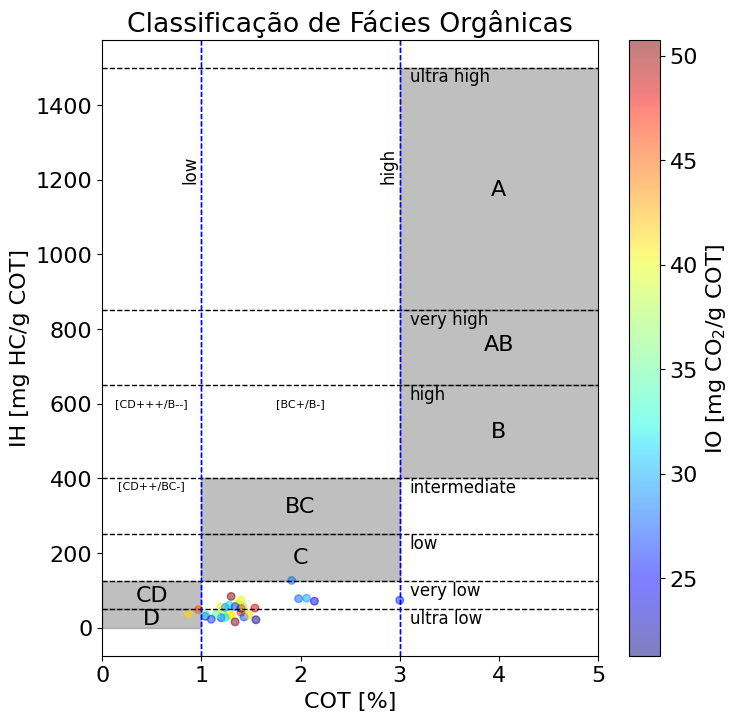

In [43]:
# vamos ao um pequeno plot para mostrar a relação entre TOC e HI

from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches

plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(8,8))

# definição das classes e áreas 
D_class = [(0,0),(0,50),(1,50),(1,0),(0,0)]
CD_class = [(0,50),(0,125),(1,125),(1,50),(0,50)]
C_class = [(1,125),(3,125),(3,250),(1,250),(1,125)]
BC_class = [(1,250),(3,250),(3,400),(1,400),(1,250)]
B_class = [(3,400),(20,400),(20,650),(3,650),(3,400)]
AB_class = [(3,650),(20,650),(20,850),(3,850),(3,650)]
A_class = [(3,850),(20,850),(20,1500),(3,1500),(3,850)]

ax.add_patch(plt.Polygon(D_class,color='gray',alpha=0.5))
ax.add_patch(plt.Polygon(CD_class,color='gray',alpha=0.5))
ax.add_patch(plt.Polygon(C_class,color='gray',alpha=0.5))
ax.add_patch(plt.Polygon(BC_class,color='gray',alpha=0.5))
ax.add_patch(plt.Polygon(B_class,color='gray',alpha=0.5))
ax.add_patch(plt.Polygon(AB_class,color='gray',alpha=0.5))
ax.add_patch(plt.Polygon(A_class,color='gray',alpha=0.5))

# classes
plt.text(0.5,25,'D',fontsize=16,va='center',ha='center')
plt.text(0.5,87.5,'CD',fontsize=16,va='center',ha='center')
plt.text(2,187.5,'C',fontsize=16,va='center',ha='center')
plt.text(2,325,'BC',fontsize=16,va='center',ha='center')
plt.text(4,525,'B',fontsize=16,va='center',ha='center')
plt.text(4,759,'AB',fontsize=16,va='center',ha='center')
plt.text(4,1175,'A',fontsize=16,va='center',ha='center')

# plota os valores em scatter ###
plt.scatter(df_out["COT"],df_out["IH"],c=df_out["IO"],
            s=30,cmap=cm.jet,alpha=0.5,label='SES189')

# ###############################
plt.xlabel('COT [%]')
plt.xlim([0,5])
plt.ylabel('IH [mg HC/g COT]')
plt.title('Classificação de Fácies Orgânicas')

his = [50,125,250,400,650,850,1500]
his_text = ['ultra low','very low','low','intermediate','high','very high','ultra high']

for yp,histext in enumerate(his_text):
    plt.axhline(his[yp],linestyle='--',color='k',linewidth=1)
    plt.text(3.1,his[yp],histext,fontsize=12,va='top')
    
cots = [1,3]
cots_text = ['low','high']
for xp,cotstext in enumerate(cots_text):
    plt.axvline(cots[xp],linestyle='--',color='b',linewidth=1)
    plt.text(cots[xp]-0.2,1200,cotstext,fontsize=12,rotation=90,ha='left')
    
plt.axvline(1,linestyle='--',color='b',linewidth=1)
plt.axvline(3,linestyle='--',color='b',linewidth=1)

# classificação extra
plt.text(0.5,600,'[CD+++/B--]',fontsize=8,va='center',ha='center')
plt.text(2,600,'[BC+/B-]',fontsize=8,va='center',ha='center')
plt.text(0.5,380,'[CD++/BC-]',fontsize=8,va='center',ha='center')

cbar = plt.colorbar()
cbar.ax.set_ylabel('IO [mg CO$_{2}$/g COT]', rotation=90)

plt.show()
